In [ ]:
#!pip install tensorflow==1.14.0

In [ ]:
#!pip install keras==2.3.1

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
#Give dataset path
train_path = '/content/drive/My Drive/Multiclass_cnn/Multi'
test_path = '/content/drive/My Drive/Multiclass_cnn/Multi_test'

In [ ]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
print(vgg.output)
print(vgg.input)

Tensor("block5_pool/MaxPool:0", shape=(?, 7, 7, 512), dtype=float32)
Tensor("input_1:0", shape=(?, 224, 224, 3), dtype=float32)


In [ ]:
#ls -lart /content/drive/'My Drive'/VGG/mymodel.h5

In [ ]:
len(vgg.layers)

19

In [ ]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
# useful for getting number of classes
folders = glob('/content/drive/My Drive/Multiclass_cnn/Multi_test/*')
print(len(folders))

5


In [ ]:
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
# Data Augmentation
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
# Make sure you provide the same target size as initialied for the image size
train_set = train_datagen.flow_from_directory('/content/drive/My Drive/Multiclass_cnn/Multi',
                                                 target_size = (224, 224),
                                                 batch_size = 100,
                                                 class_mode = 'categorical')

Found 1039 images belonging to 5 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/content/drive/My Drive/Multiclass_cnn/Multi_test',
                                            target_size = (224, 224),
                                            batch_size = 100,
                                            class_mode = 'categorical')

Found 214 images belonging to 5 classes.


In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

#lr_scheduler = LearningRateScheduler(lr_schedule)

#lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                               cooldown=0,
#                               patience=5,
#                               min_lr=0.5e-6)

#num_epochs = 1000
#num_batch_size = 32

checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/Multiclass_cnn/vgg16_mymodel_5.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=15,
  steps_per_epoch=10,
  validation_steps=10,
    callbacks=callbacks ,verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)


Epoch 1/15
10/10 [==============================] - 896s 90s/step - loss: 380.8295 - accuracy: 0.5016 - val_loss: 168.1956 - val_accuracy: 0.7642

Epoch 00001: val_loss improved from inf to 168.19562, saving model to /content/drive/My Drive/Multiclass_cnn/vgg16_mymodel_5.h5
Epoch 2/15
10/10 [==============================] - 948s 95s/step - loss: 201.4535 - accuracy: 0.7880 - val_loss: 112.8576 - val_accuracy: 0.8032

Epoch 00002: val_loss improved from 168.19562 to 112.85756, saving model to /content/drive/My Drive/Multiclass_cnn/vgg16_mymodel_5.h5
Epoch 3/15
10/10 [==============================] - 847s 85s/step - loss: 181.1584 - accuracy: 0.8417 - val_loss: 202.5959 - val_accuracy: 0.8506

Epoch 00003: val_loss did not improve from 112.85756
Epoch 4/15
10/10 [==============================] - 868s 87s/step - loss: 139.2784 - accuracy: 0.8754 - val_loss: 59.0747 - val_accuracy: 0.8733

Epoch 00004: val_loss improved from 112.85756 to 59.07468, saving model to /content/drive/My Driv

In [ ]:
import numpy as np

from keras.preprocessing import image
from tensorflow.python.keras.models import load_model
test_image = image.load_img('/content/drive/My Drive/Multiclass_cnn/Multi/cow/cow138.jpg', target_size = (224, 224))

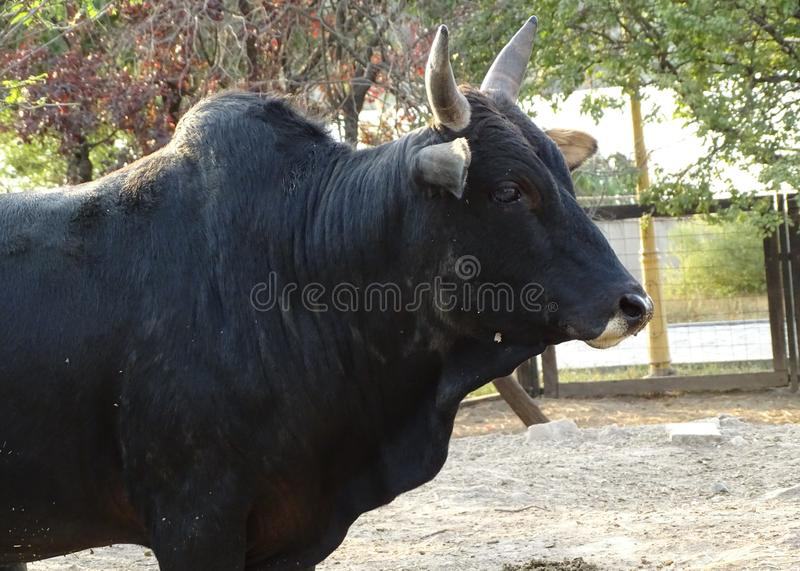

In [ ]:
#show image
from IPython.display import display # to display images
from PIL import Image
from keras.preprocessing import image
img = Image.open('/content/drive/My Drive/Multiclass_cnn/Multi/cow/cow138.jpg')
display(img)

In [ ]:
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
model = load_model('/content/drive/My Drive/Multiclass_cnn/vgg16_mymodel_5.h5')
result = model.predict(test_image)
result = result[0]
classes = ['cat','cow', 'horse', 'nikita','ram']

label_name = {classes[i]: result[i] for i in range(len(result))}
label_name


{'cat': 0.0, 'cow': 1.0, 'horse': 0.0, 'nikita': 0.0, 'ram': 0.0}

In [ ]:
output = max(label_name, key=label_name.get)
print(output)

cow


In [ ]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [3]:
##To create the classification matrixx and other matrices to see the proper results
##Prepare the confusion matrix fo this model resnet50 for 5 class image classification
##On Trained Data
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
from  matplotlib import pyplot as plt
import pandas as pd
import os
listing =[]
classes = ['cat','cow','horse','nikita','ram']
model = load_model('/content/drive/My Drive/Multiclass_cnn/vgg16_mymodel_5.h5')
for cls in classes:
  for count, filename in enumerate(os.listdir("/content/drive/My Drive/Multiclass_cnn/Multi/"+cls)):
    test_image = image.load_img(r'/content/drive/My Drive/Multiclass_cnn/Multi/'+cls+'/'+filename, target_size = (224,224))
    #plt.imshow(test_image,cmap='gray')
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(test_image)
    result = result[0]
    label_name = {classes[i]: result[i] for i in range(len(result))}
    output = max(label_name, key=label_name.get)
    listing.append((cls,output))
  
x=pd.DataFrame(listing, columns=('Actual', 'Predicted'))

[[198   0   7   0   0]
 [  0 194  15   1   0]
 [  0   6 197   0   0]
 [  1   3   8 195   5]
 [  1   3   7  28 170]]


Text(33.0, 0.5, 'Predicted')

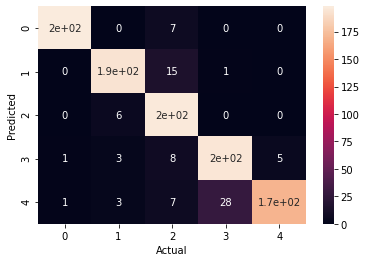

In [4]:
# Example of a confusion matrix in Python
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
le= preprocessing.LabelEncoder()

x['Actual']=le.fit_transform(x['Actual'])
x['Predicted']=le.fit_transform(x['Predicted'])

results = confusion_matrix(x['Actual'], x['Predicted'])
print(results)

plt.figure()
sns.heatmap(results, annot=True)
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [5]:
from sklearn.metrics import classification_report
print(classification_report(x['Actual'],x['Predicted']))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       205
           1       0.94      0.92      0.93       210
           2       0.84      0.97      0.90       203
           3       0.87      0.92      0.89       212
           4       0.97      0.81      0.89       209

    accuracy                           0.92      1039
   macro avg       0.92      0.92      0.92      1039
weighted avg       0.92      0.92      0.92      1039



In [6]:
##Prepare the confusion matrix fo this model resnet50 for 5 class image classification
##On test Data 
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
from  matplotlib import pyplot as plt
import pandas as pd
import os
listing =[]
classes = ['cat','cow','horse','nikita','ram']
model = load_model('/content/drive/My Drive/Multiclass_cnn/mymodelresnet1_5.h5')
for cls in classes:
  for count, filename in enumerate(os.listdir("/content/drive/My Drive/Multiclass_cnn/Multi_test/"+cls)):
    test_image = image.load_img(r'/content/drive/My Drive/Multiclass_cnn/Multi_test/'+cls+'/'+filename, target_size = (224,224))
    #plt.imshow(test_image,cmap='gray')
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(test_image)
    result = result[0]
    label_name = {classes[i]: result[i] for i in range(len(result))}
    output = max(label_name, key=label_name.get)
    listing.append((cls,output))
  
x=pd.DataFrame(listing, columns=('Actual', 'Predicted'))

[[21  0  1  0  0]
 [ 0 23  2  0  0]
 [ 0  0 28  0  0]
 [ 0  1  1 74 13]
 [ 0  0  0  6 45]]


Text(33.0, 0.5, 'Predicted')

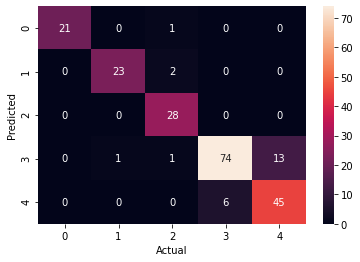

In [7]:
# Example of a confusion matrix in Python
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
le= preprocessing.LabelEncoder()

x['Actual']=le.fit_transform(x['Actual'])
x['Predicted']=le.fit_transform(x['Predicted'])

results = confusion_matrix(x['Actual'], x['Predicted'])
print(results)

plt.figure()
sns.heatmap(results, annot=True)
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [15]:
ls -lart /content/drive/'My Drive'/Multiclass_cnn/Multi_test/horse |wc -l

29


In [8]:
from sklearn.metrics import classification_report
print(classification_report(x['Actual'],x['Predicted']))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        22
           1       0.96      0.92      0.94        25
           2       0.88      1.00      0.93        28
           3       0.93      0.83      0.88        89
           4       0.78      0.88      0.83        51

    accuracy                           0.89       215
   macro avg       0.91      0.92      0.91       215
weighted avg       0.89      0.89      0.89       215



In [19]:
##Prepare the confusion matrix fo this model resnet50 for 5 class image classification
##On test Data 
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
from  matplotlib import pyplot as plt
import pandas as pd
import os
listing =[]
classes = ['cat','cow','horse','nikita','ram']
model = load_model('/content/drive/My Drive/Multiclass_cnn/mymodelresnet1_5.h5')
for cls in classes:
  for count, filename in enumerate(os.listdir("/content/drive/My Drive/Multiclass_cnn/testmodel/"+cls)):
    test_image = image.load_img(r'/content/drive/My Drive/Multiclass_cnn/testmodel/'+cls+'/'+filename, target_size = (224,224))
    #plt.imshow(test_image,cmap='gray')
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(test_image)
    result = result[0]
    label_name = {classes[i]: result[i] for i in range(len(result))}
    output = max(label_name, key=label_name.get)
    listing.append((cls,output))
  
x=pd.DataFrame(listing, columns=('Actual', 'Predicted'))

[[2 0 0 0 0]
 [0 4 0 0 0]
 [0 0 7 0 0]
 [0 0 0 2 0]
 [0 0 0 0 1]]


Text(33.0, 0.5, 'Predicted')

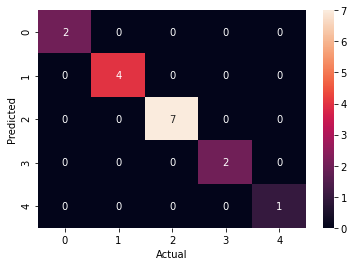

In [20]:
# Example of a confusion matrix in Python
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
le= preprocessing.LabelEncoder()

x['Actual']=le.fit_transform(x['Actual'])
x['Predicted']=le.fit_transform(x['Predicted'])

results = confusion_matrix(x['Actual'], x['Predicted'])
print(results)

plt.figure()
sns.heatmap(results, annot=True)
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [21]:
from sklearn.metrics import classification_report
print(classification_report(x['Actual'],x['Predicted']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

